<a href="https://colab.research.google.com/github/Sasha-Mikhailov/Aegea_export/blob/master/Aegea_Export_(public_v_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Скрипт для экспорта заметок из Эгеи 

версия 0.0.4

скрипт подключается к базе, качает данные о всех заметках и сохраняет результат в две гугл таблички

для подключения к базе данных Эгеи надо в настройках хостинга включить возможность подключения извне и вбить ниже данные:
- веб-адрес или IP хостинга, 
- название базы данных, 
- к ней логин и пароль.

**РЕЗУЛЬТАТ** → гугл таблица и файл

## сохранить копию тетради к себе на гугл диск
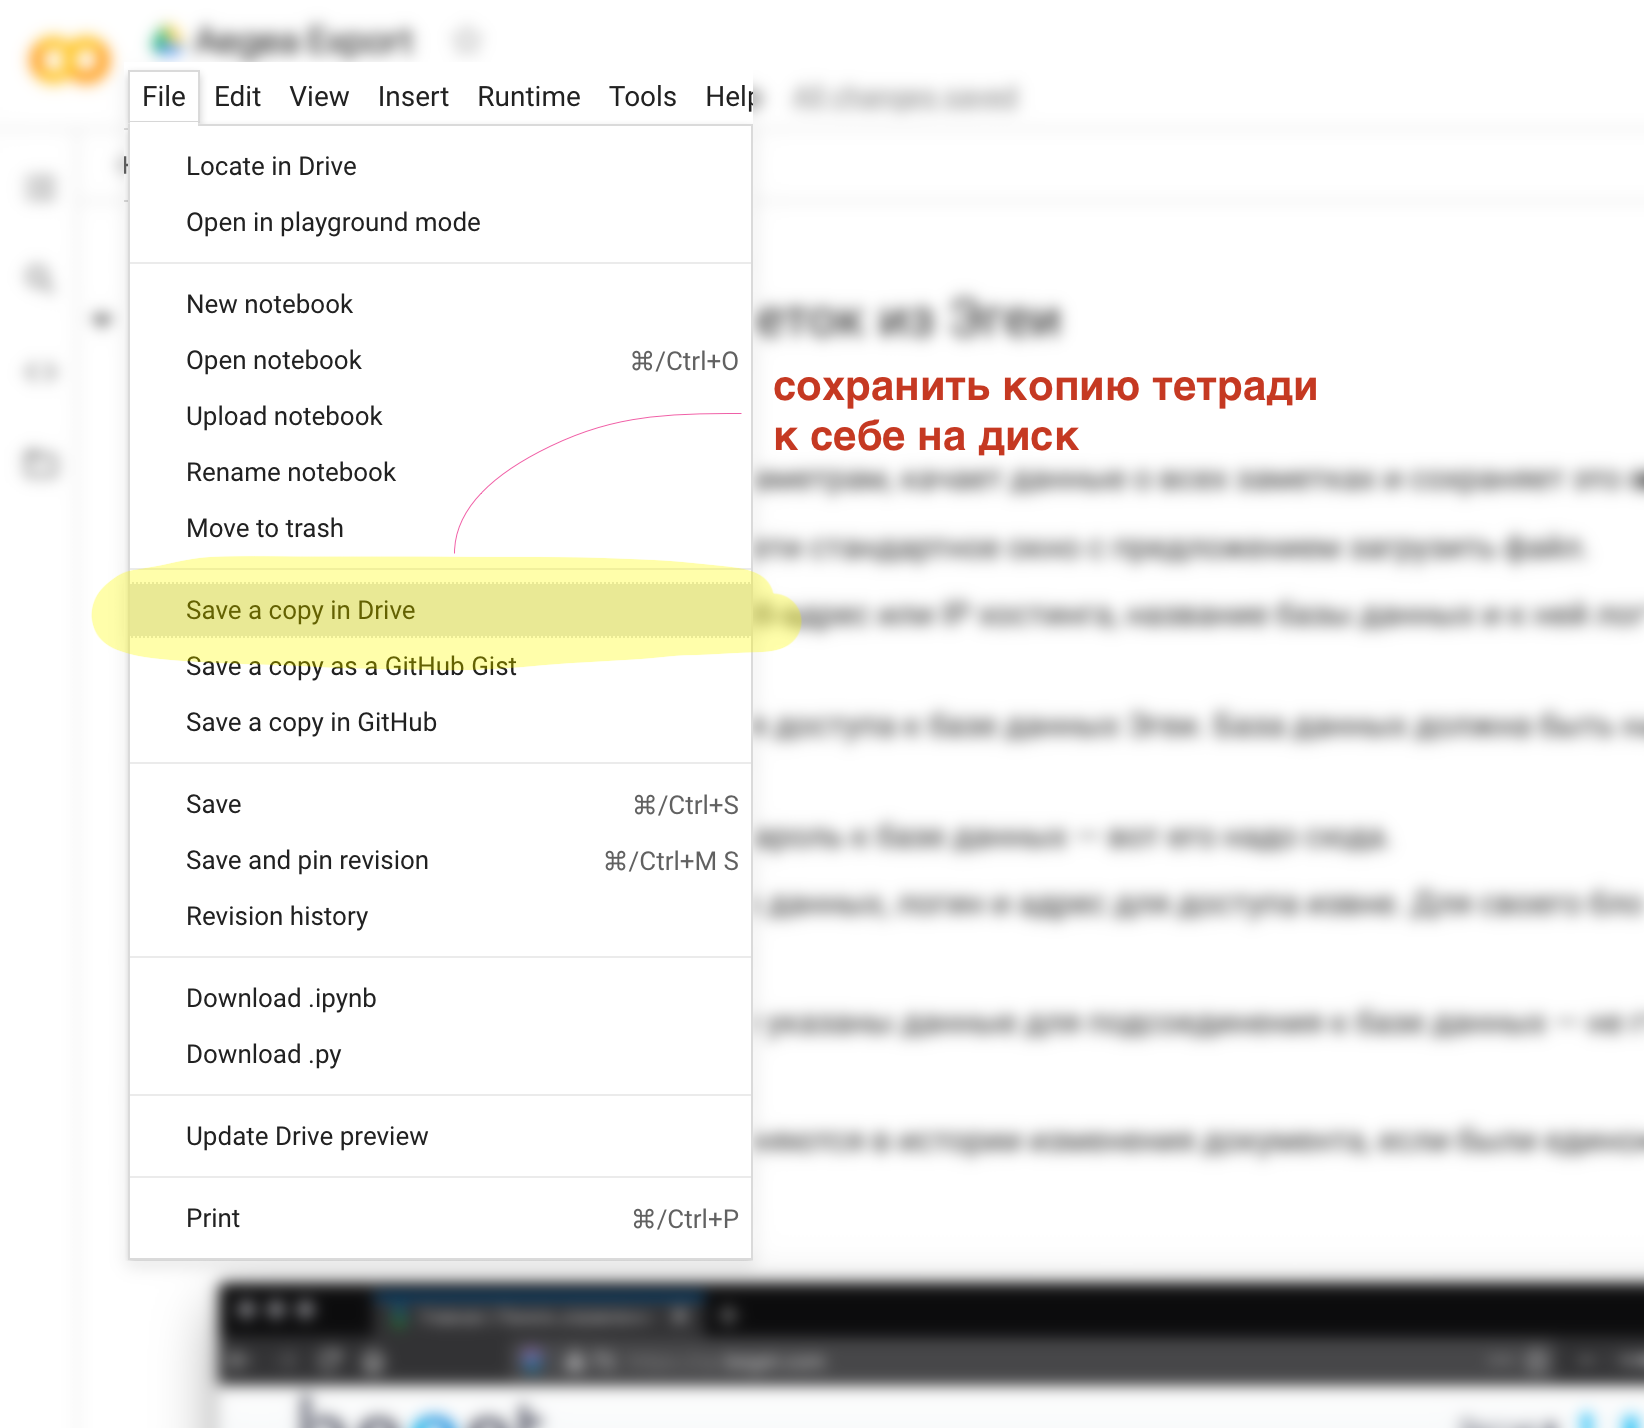

чтобы всё заработало нужны данные для доступа к базе данных Эгеи. База данных должна быть на хостинге, где и сам блог.



---

**! Нужно включить доступ к базе извне.**  
(_По умолчанию доступ к базе извне выключен: самому блогу-то он не нужен — они ведь крутятся на одной машине._) 
---


при создании блога надо было указать пароль к базе данных — вот его надо сюда.  

Кроме пароля, нужно ещё название базы данных, логин и адрес для доступа извне. Для своего блога я нашёл это в личном кабинете хостинга.  

**ВАЖНО!** В этой тетради в открытом виде указаны данные для подсоединения к базе данных — не пересылайте и не открывайте публичный доступ к этой тетради. 

**ВАЖНО!** (если что) пароли-логины сохраняются в истории изменения документа, если были единожды сохранены.

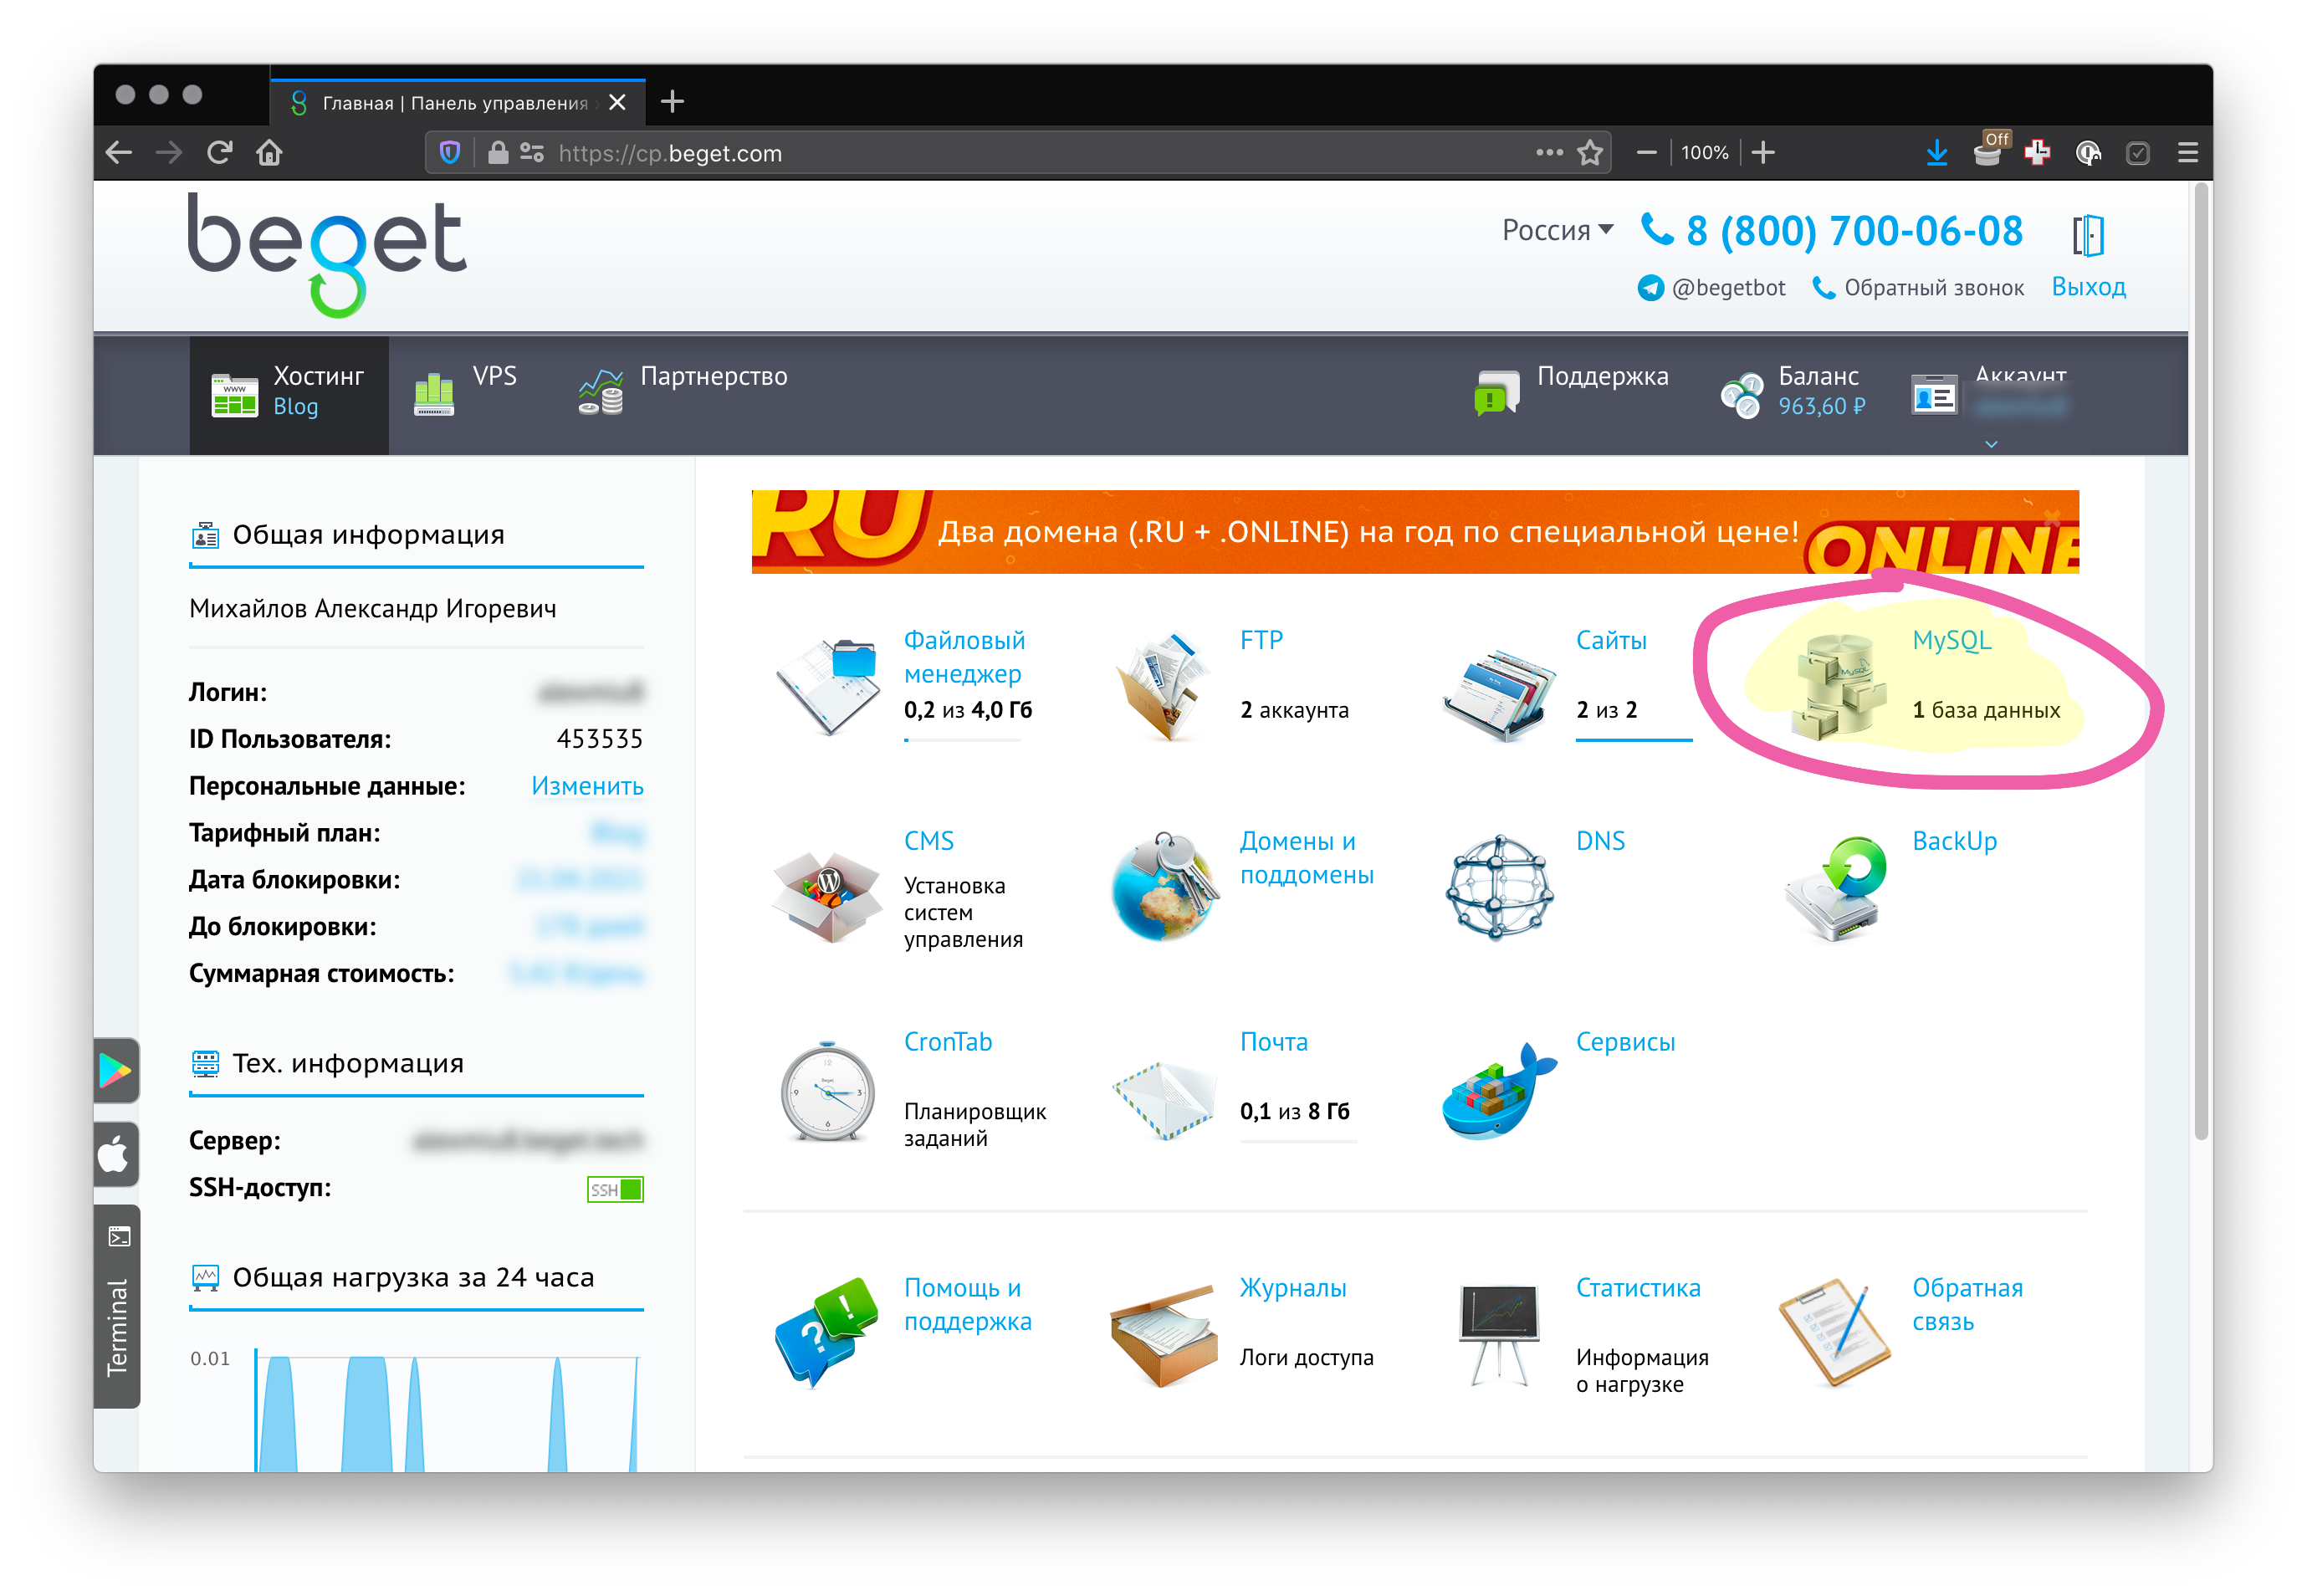

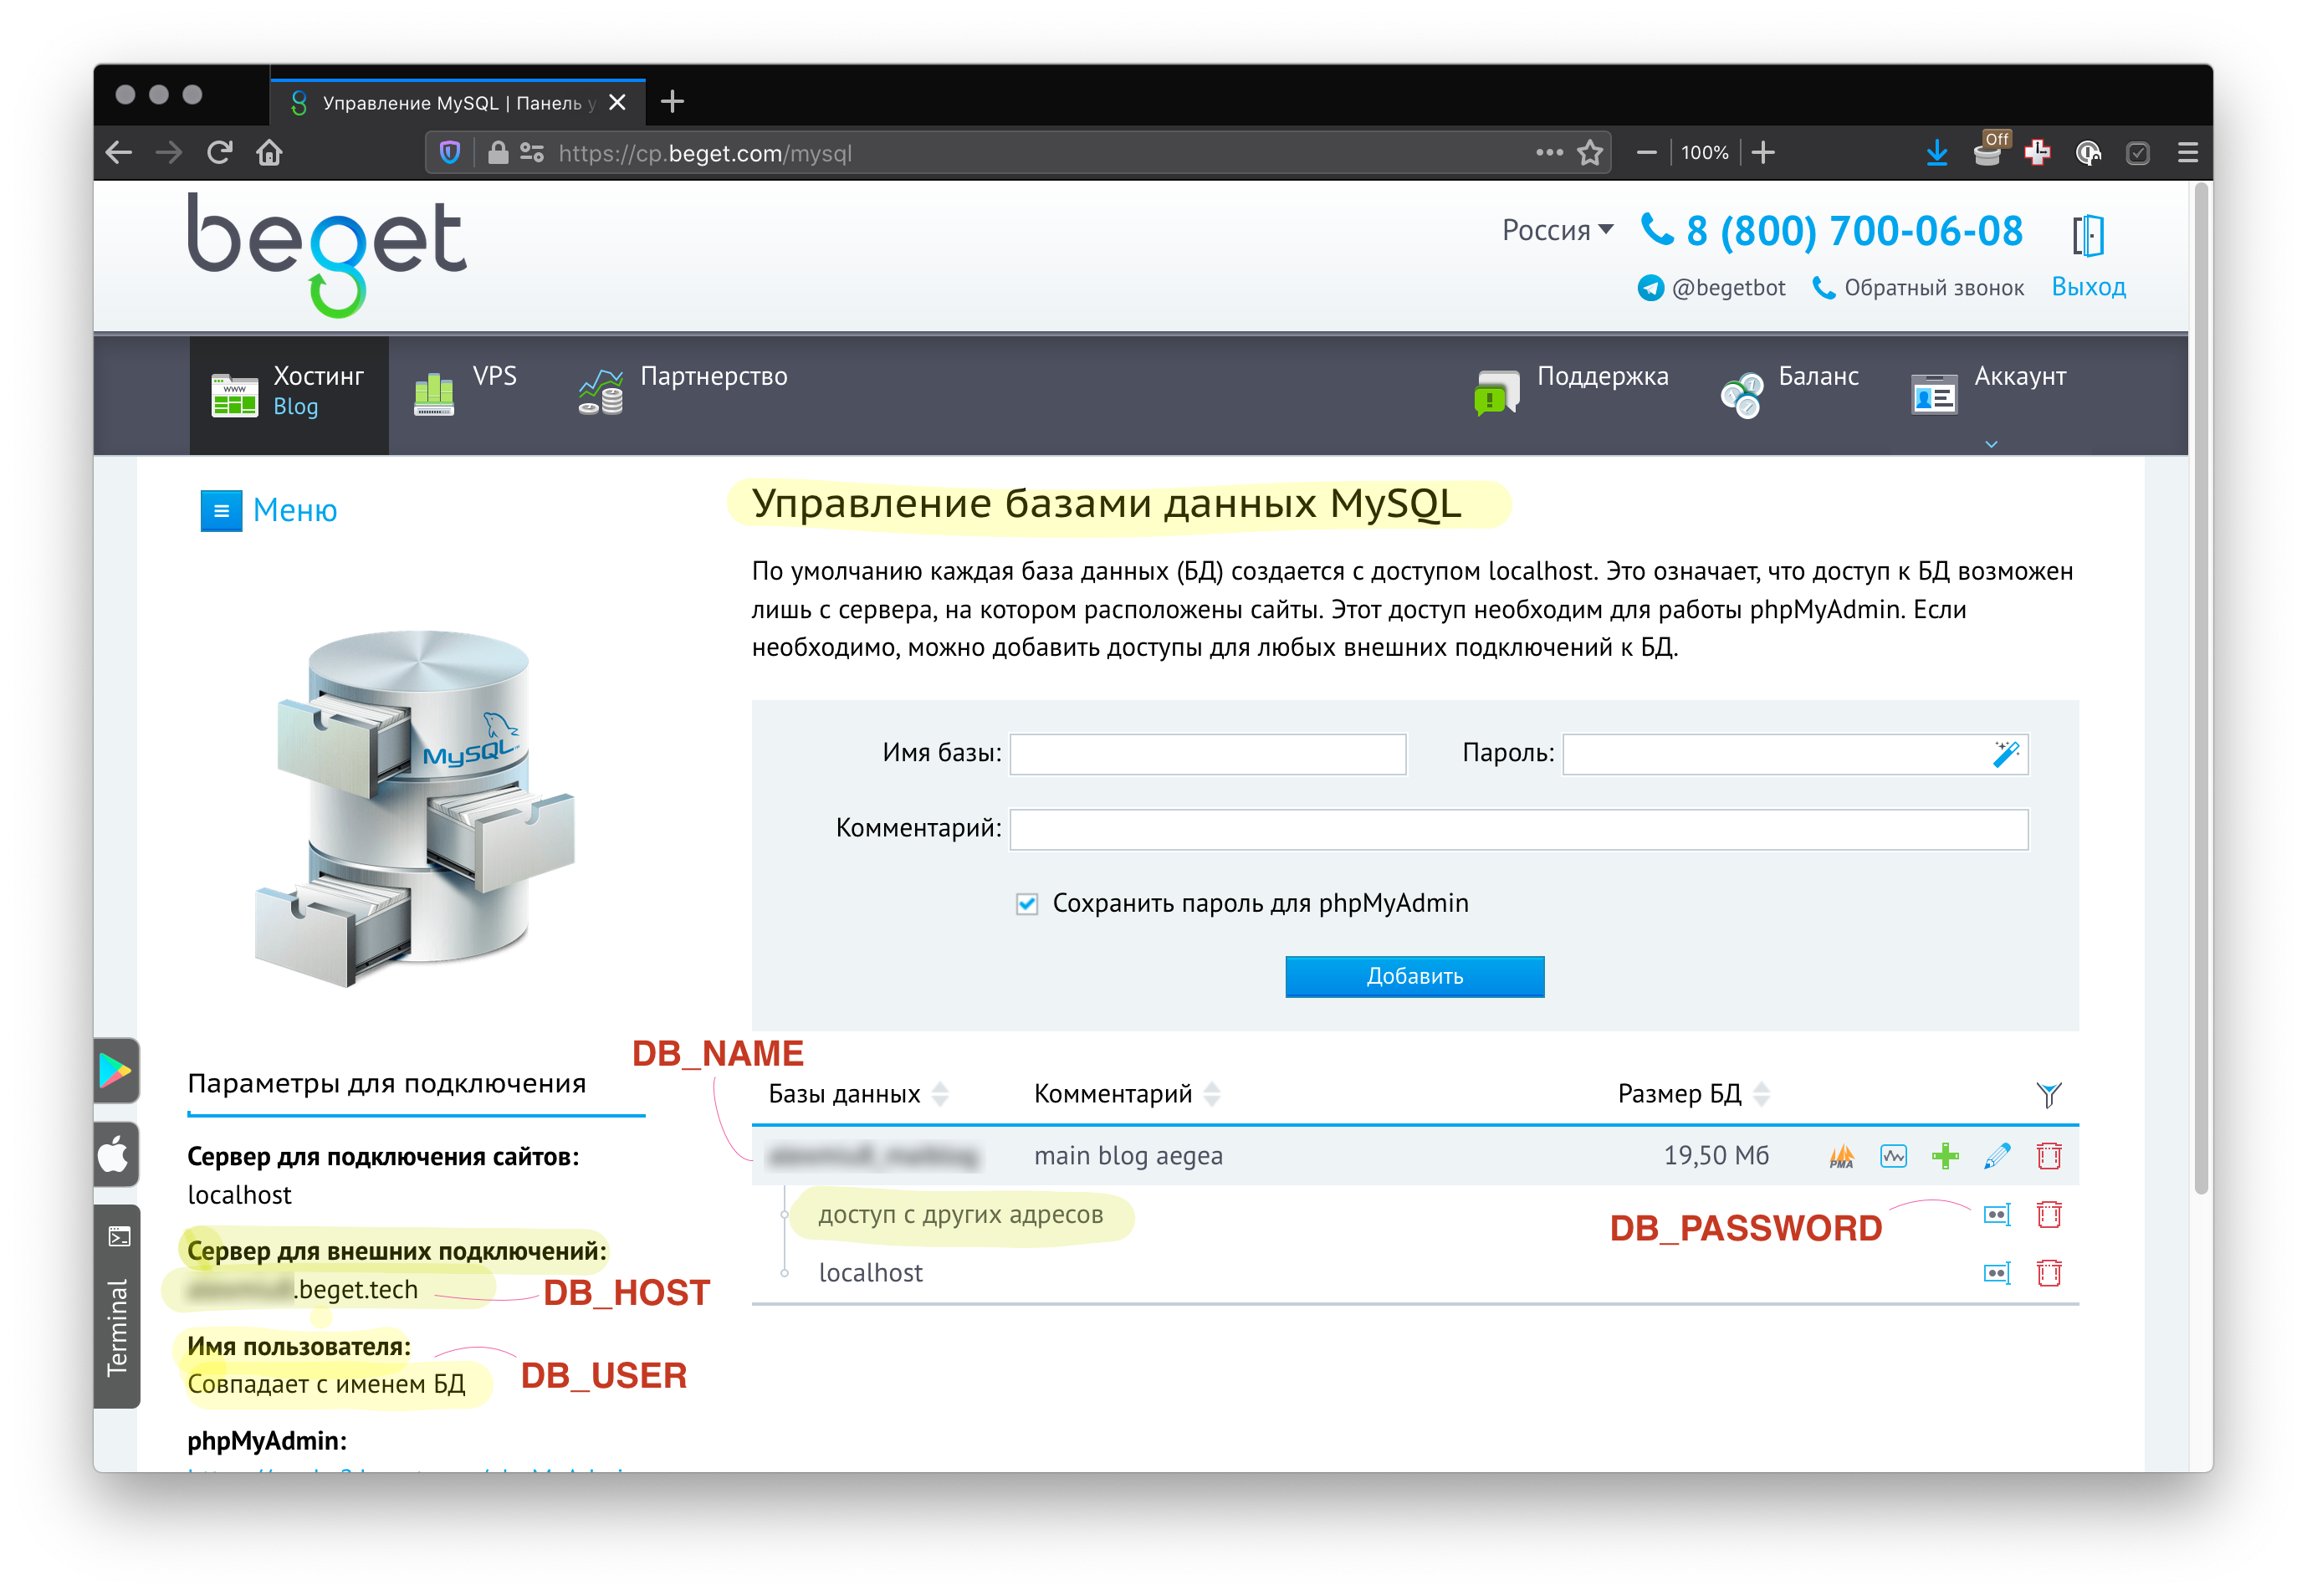

In [1]:
# credentials to connect to the database

# address (IP or web-adress) of machine where database is
# ("localhost" — if the script executes on the same machine)
# for example 'sami365.beget.tech'
# or '87.250.250.242'
DB_HOST        = 'rc1a-6cd5dcm91fwyfa9x.mdb.yandexcloud.net'  

DB_NAME        = 'aegea_backup' # name of the database
DB_USER        = 'aegea_viewer'  # username to acces the database 
                                      # (in my case db user is the same as db name)
DB_PASSWORD    = 'aegea_viewer' # password to acces the database

BLOG_URL       = 'domain.com/blog/all/' # just to make nice final links 
                                       # with '/' at the end, please :-)
                                       # and probably with '…/blog/all/'

# check if URL ends with '/'
if (BLOG_URL != '') and (BLOG_URL[-1] != '/'):
  BLOG_URL += '/'

# set to True if want to download result directly
download_directly = False

## выбрать Google аккаунт, куда записывать таблицу

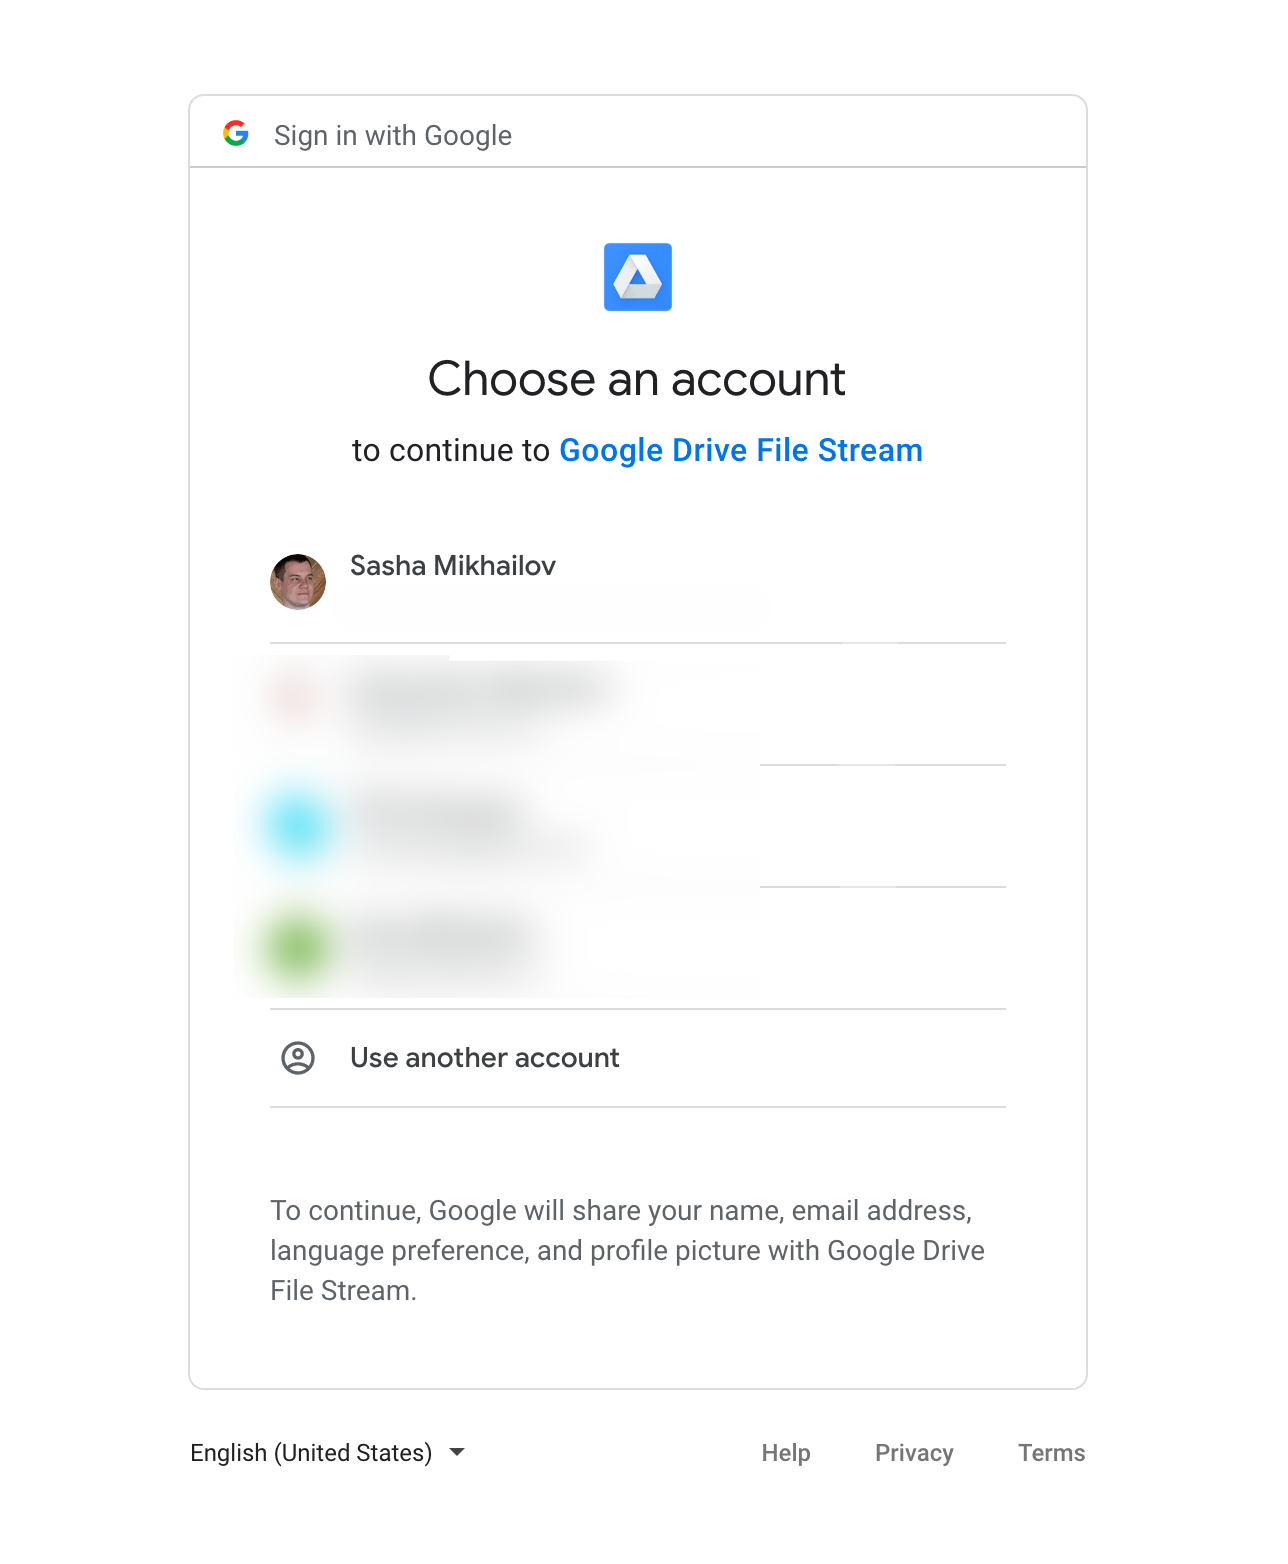

## согласиться со списком неоходимых разрешений

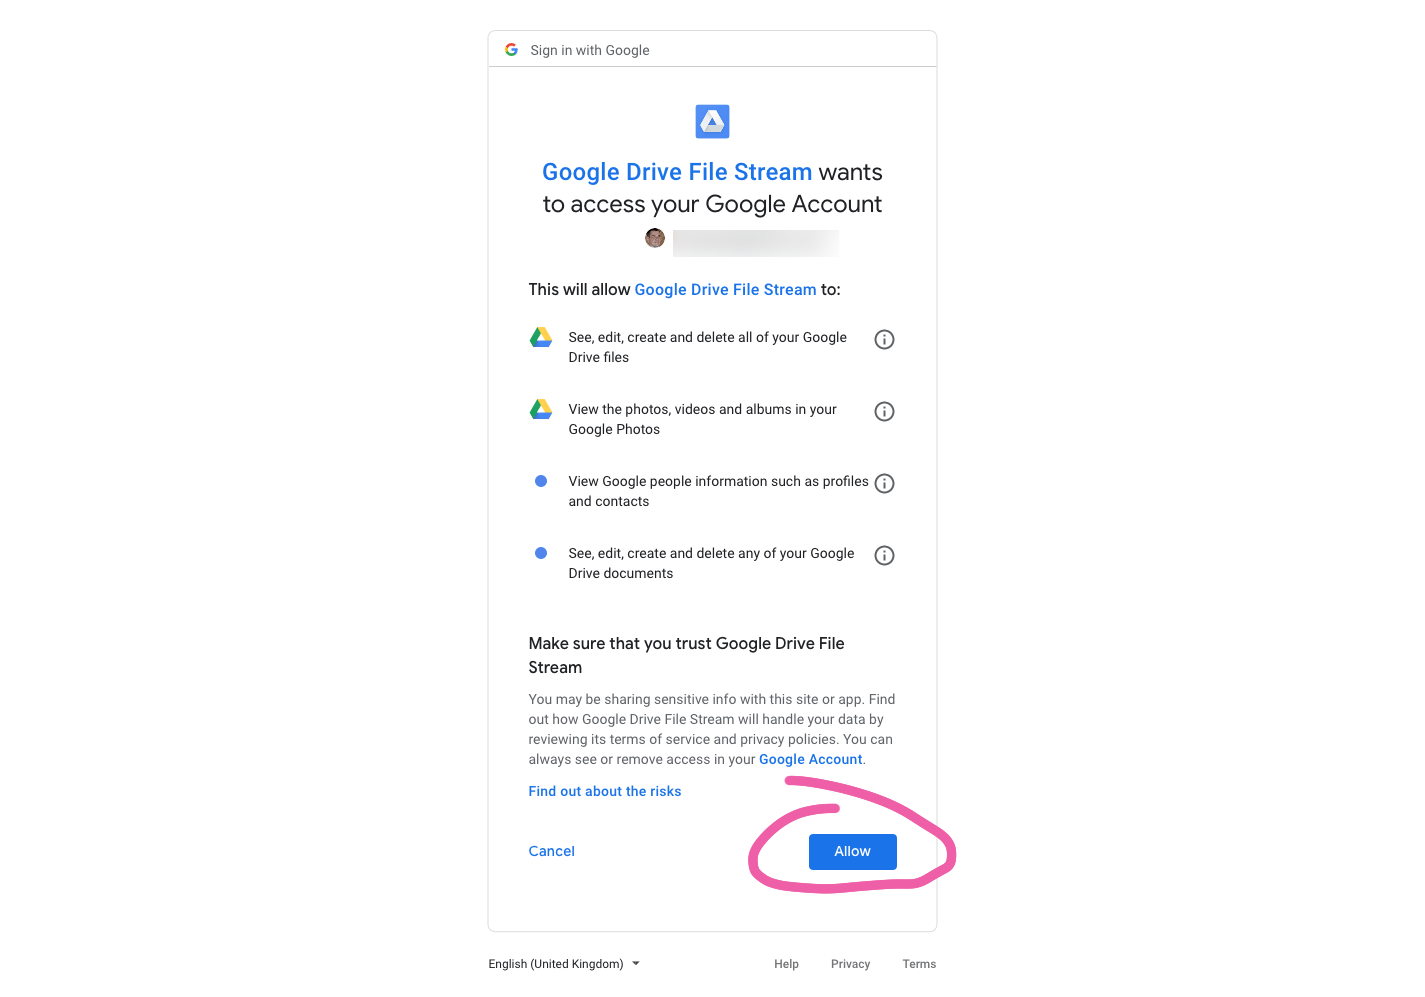

## скопировать токен в окошечко (ниже исполняемой ячейки с кодом)

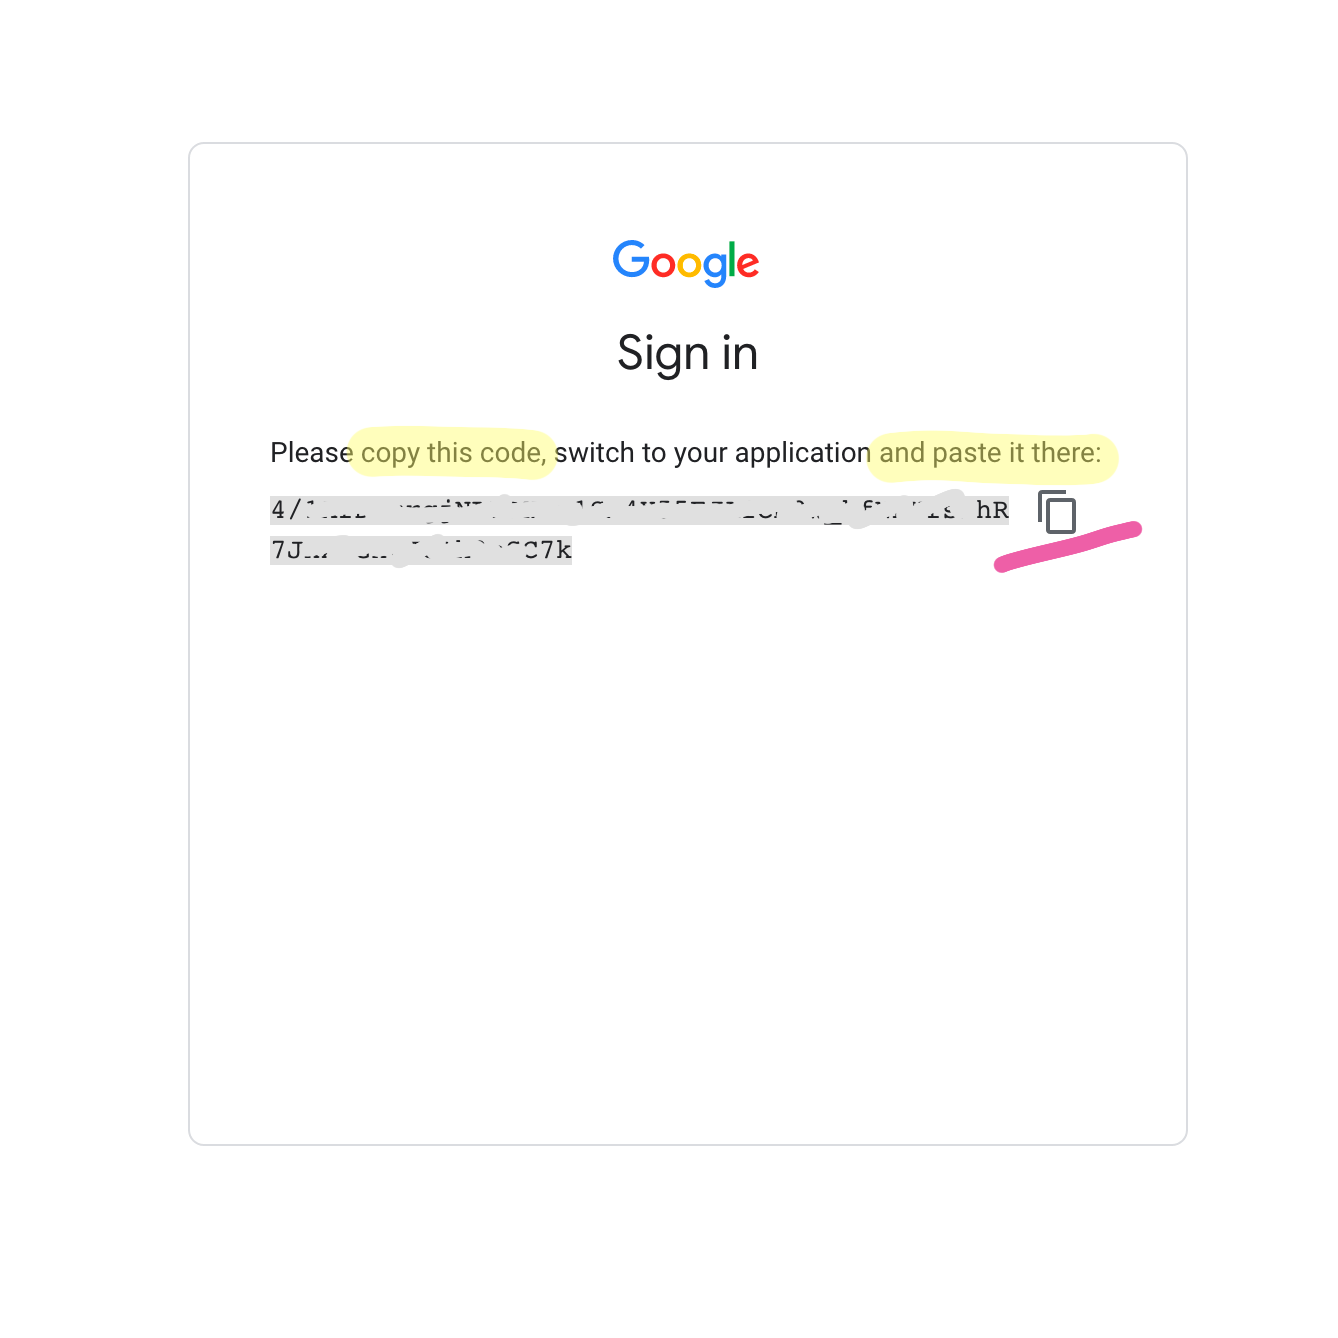

## перейти по ссылке, дать доступ, скопировать токен в окошко (2)

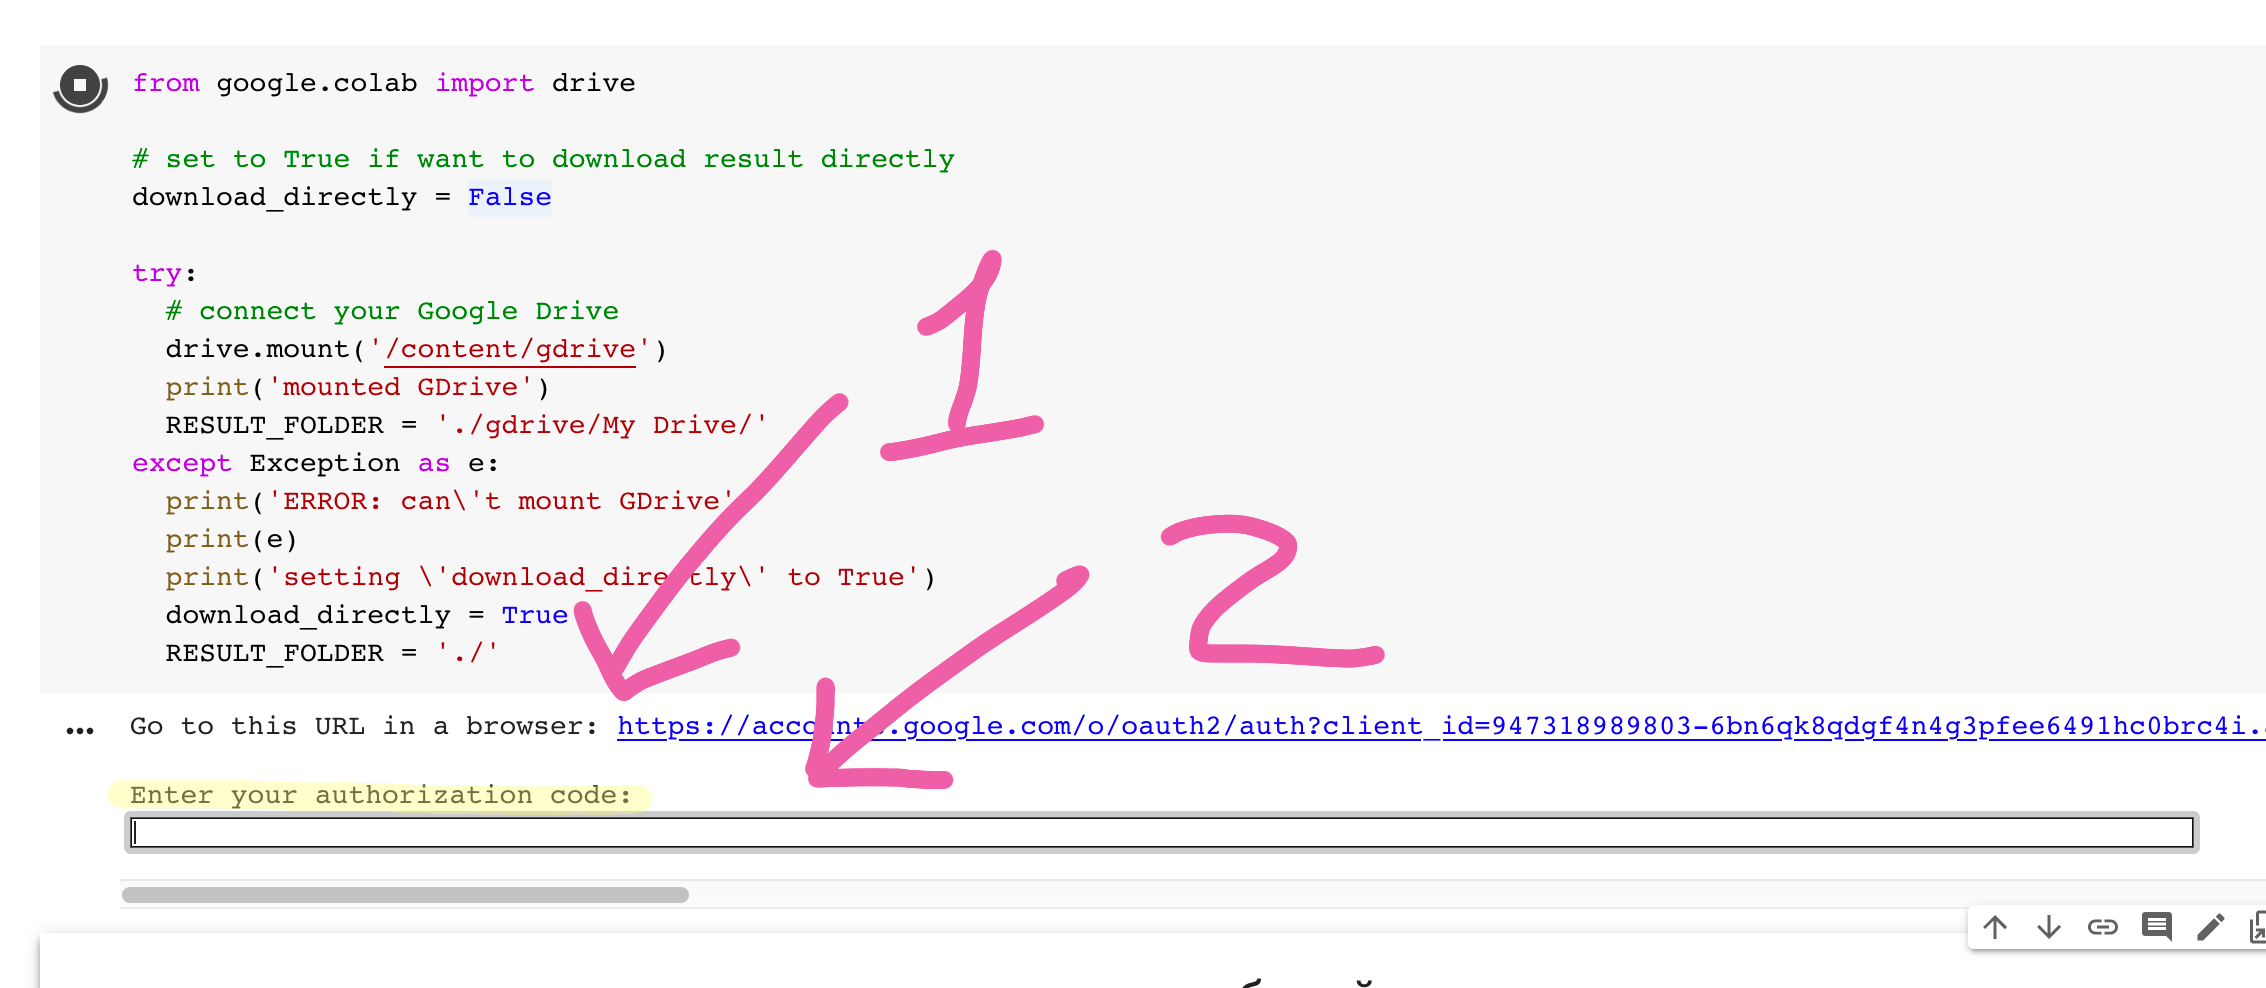

In [2]:
from google.colab import auth, files
auth.authenticate_user()

# после того как ввели данные для соединения с базой данных, надо запустить исполнение кода через меню `Runtime` → `Run all`

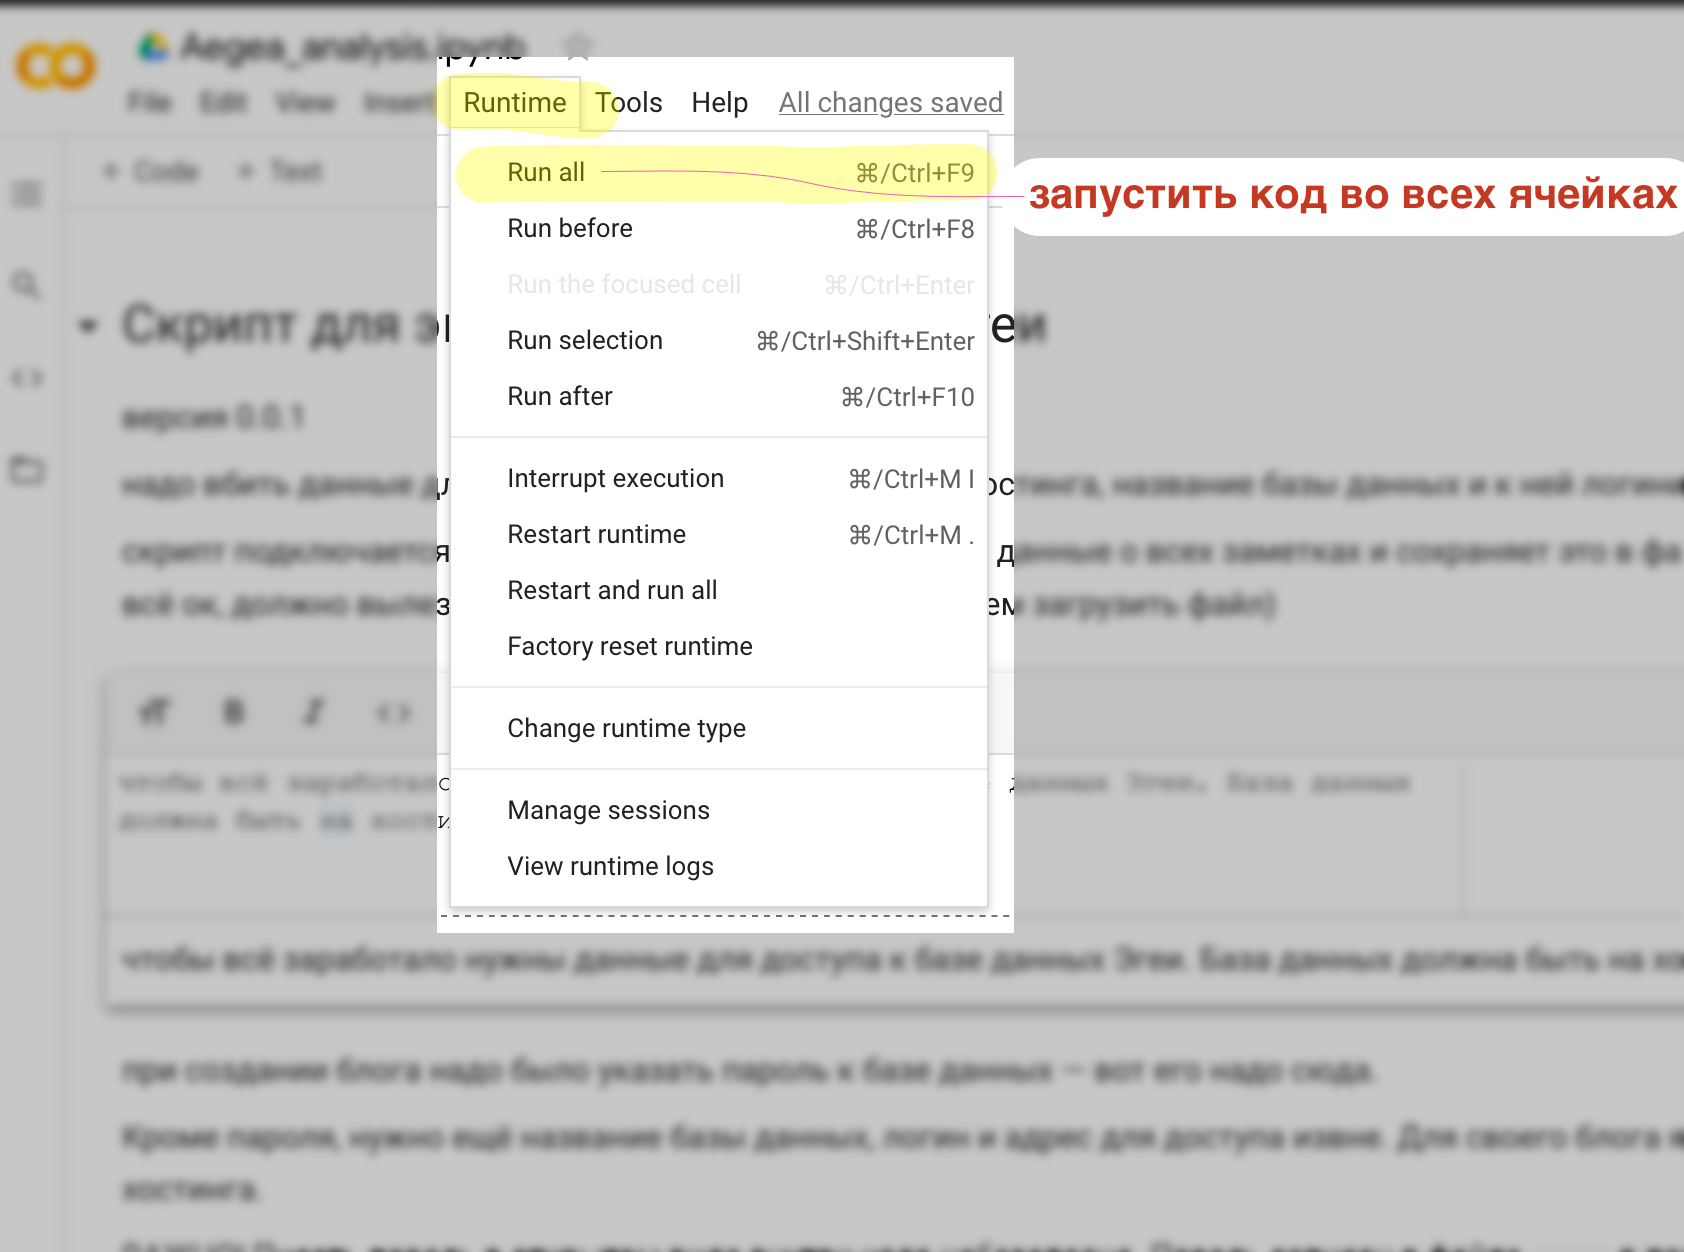

In [3]:
#@title Download dependencies: connector to MySQL and Google Sheets
!pip install mysql-connector-python
!pip install gspread --upgrade

Requirement already up-to-date: gspread in /usr/local/lib/python3.6/dist-packages (3.6.0)


In [4]:
mkdir ~/.mysql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" -O ~/.mysql/root.crt && \
chmod 0600 ~/.mysql/root.crt


mkdir: cannot create directory ‘/root/.mysql’: File exists


In [5]:
#@title imports necesseary libraries
from sqlalchemy import create_engine
import mysql.connector

import pandas as pd
import os

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [6]:
#@title set connection to the database
def connect_to_database(ssl_args = {}):
    con_string = f'mysql+mysqlconnector://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:3306/{DB_NAME}'

    try:
        engine = create_engine(con_string,
                               connect_args=ssl_args)
        print('successfully connected to the database')
        return engine
    except Exception as e:
        print('ERROR! can\'t connect to the database')
        engine = None
        raise e
        

    

In [7]:
#@title get data from the database
def get_data_from_aegea(QUERY, engine):
       
    try:
        df = pd.read_sql(QUERY, engine)
        print(f'got {len(df)} rows from the database')
    except Exception as e:
        print('ERROR during fetching data from database')
        print(e)
        df = pd.DataFrame()

    return df


In [8]:
#@title get Aegea's data to a file and download it 
def download_data(df, filepath, download = False):
  
  if len(df) > 0:
    try:
      df.to_csv(filepath, index=False)
      print(f'starting download {filepath}')
      files.download(filepath)
    except Exception as e:
      print(f'ERROR during writing the file with path {result_filepath}')

      

In [9]:
#@title prepare queries for database
READ_COLUMN = 'ReadCount' # HitCount

agg_data_query = f'''
    select notes.Title as "Заголовок"
        , from_unixtime(notes.Stamp) as "Дата"
        , notes.Text as "Текст"
        , CONCAT("{BLOG_URL}", notes.OriginalAlias) as url
        , char_length(notes.Text) as "Знаков в тексте"
        , coalesce(v.views, 0) as "Просмотры"
        , coalesce(c.comments_count, 0) as "Количество комментариев"
        , notes.IsFavourite as "Избранная заметка"
        , notes.ID as "ID заметки"
        , t.tags as "Тэги"
    from e2BlogNotes notes
    left join (
        select EntityID
            , sum({READ_COLUMN}) as views
        from e2BlogActions
        group by 1
        ) as v on v.EntityID = notes.ID
    left join (
        select NoteID
          , count(distinct ID) as comments_count
        from e2BlogComments
        group by 1
            ) as c on c.NoteID = notes.ID
    left join (
        select nk.NoteID as note_id
            , GROUP_CONCAT(k.Keyword SEPARATOR ', ') as tags
        from e2BlogNotesKeywords as nk
        left join e2BlogKeywords as k
            on k.ID = nk.KeywordID
        group by nk.NoteID
        ) as t on t.note_id = notes.ID
  '''

views_by_days_query = f'''
  select EntityID as "ID заметки"
       , date(from_unixtime(Stamp)) as "Дата"
       , sum(ReadCount) as "Просмотры за день"
  from e2BlogActions
  group by 1, 2
  '''

tags_by_notes = '''
  SELECT notes.id as "ID заметки"
    , notes.Title as "Заголовок"
    , tags.Keyword as "Тeг"  
  from e2BlogNotes notes
  left join e2BlogNotesKeywords nk
    on nk.NoteID = notes.ID 
  left join e2BlogKeywords tags
    on tags.ID = nk.KeywordID 
  order by from_unixtime(notes.Stamp)
  '''



In [10]:
#@title transform dataframe to google sheet
def prepare_dates_in_df(df):
  # prepare data in columns with dates  
  dates_str = ['дата']

  cols_with_dates = df.select_dtypes(include = 'datetime').columns.to_list()

  for col in df.columns:
    for date_str in dates_str:
      if (date_str in col.lower()) and \
                      (col not in cols_with_dates):
        cols_with_dates += [col]

  if cols_with_dates:
    for col in cols_with_dates:
      df[col] = df[col].astype('str')

  return df

def get_google_sheet(gsheet_name):
  # open or create spreadsheet
  try:
    gsheet = gc.open(title = gsheet_name)
    print(f'opening Google Sheet {gsheet_name}')
  except:
    gsheet = gc.create(title = gsheet_name)
    print(f'can\'t find Google Sheet {gsheet_name}, creating one')

  return gsheet


def get_worksheet(df, gsheet, worksheet_name):
  # open or create worksheet
  try:
    # open if worksheet exists
    worksheet = gsheet.worksheet(worksheet_name)
    print(f'opening worksheet {worksheet_name}')
  except:
    # create if worksheet doesn't exist
    worksheet = gsheet.add_worksheet(title=worksheet_name, 
                                 rows=str(df.shape[0] + 30), 
                                 cols=str(df.shape[1] + 10))
    print(f'can\'t find worksheet {worksheet_name}, creating one')
  
  return worksheet


def df_to_gsheet(df, 
                 gsheet_name = 'aegea_notes_data', 
                 worksheet_name = 'Sheet1'):
    
  df = prepare_dates_in_df(df)

  gsheet = get_google_sheet(gsheet_name)

  worksheet = get_worksheet(df, 
                            gsheet,
                            worksheet_name)
  
  if worksheet_name != 'Sheet1':
    try:
      # remove default empty sheet 
      default_wsh = gsheet.worksheet("Sheet1") 
      gsheet.del_worksheet(default_wsh)
      print('removing default sheet "Sheet1"')
    except:
      pass

  # load the data to the worksheet of the gsheet
  worksheet.update([df.columns.values.tolist()] + 
                    df.values.tolist())
  print(f'updated {df.shape[0]} rows to {gsheet_name}/{worksheet_name}')
  print(gsheet.url)


In [11]:
#@title prepare meta data for each data slice

# set Google Sheet name to export data to
GSHEET_NAME = 'blog_aegea_export'

# prepare dict with required variables for each data slice 
data_slices = {
    'agg_data': {
        'query': agg_data_query,
        'dataframe': pd.DataFrame(),
        'gsheet_name': GSHEET_NAME, # set different name to export to separate sheets
        'worsheet_name': 'notes_data',
        },
    'notes_views': {
        'query': views_by_days_query,
        'dataframe': pd.DataFrame(),
        'gsheet_name': GSHEET_NAME, # set different name to export to separate sheets
        'worsheet_name': 'notes_views_by_days',
        },
    'notes_tags': {
        'query': tags_by_notes,
        'dataframe': pd.DataFrame(),
        'gsheet_name': GSHEET_NAME, # set different name to export to separate sheets
        'worsheet_name': 'notes_tags',
        },
}

In [12]:
if __name__ == '__main__':
  # make a SQLAlchemy engine with connection to the database
  ssl_args = {'ssl_ca': '~/.mysql/root.crt'}
  engine = connect_to_database() #ssl_args

  # if connection to the database was succesfull…
  if engine:
    # for each data slice…
    for key, data_slice in data_slices.items():
      try:
        # … extract data from the database
        data_slice['dataframe'] = get_data_from_aegea(data_slice['query'], 
                                                      engine)
        has_data = True
      except Exception as e:
        print('ERROR during getting data from database')
        print(e)
        has_data = False

      if has_data and (len(data_slice['dataframe']) > 0):
        # … and load it to a Google Sheet
        df_to_gsheet(data_slice['dataframe'], 
                    gsheet_name = data_slice['gsheet_name'],
                    worksheet_name = data_slice['worsheet_name'])  
        print(f'exported {data_slice["worsheet_name"]} to Google Sheet\n')
        
        if download_directly:
          # … and download a .csv if needed
          download_data(data_slice['dataframe'], 
                        data_slice['worsheet_name'] + '.csv')
        
  

successfully connected to the database
got 205 rows from the database
opening Google Sheet blog_aegea_export
opening worksheet notes_data
updated 205 rows to blog_aegea_export/notes_data
https://docs.google.com/spreadsheets/d/1wqqhpZU5p053b5rYJStO2BzDglp4aJzruPASxjwwYtw
exported notes_data to Google Sheet

got 2641 rows from the database
opening Google Sheet blog_aegea_export
opening worksheet notes_views_by_days
updated 2641 rows to blog_aegea_export/notes_views_by_days
https://docs.google.com/spreadsheets/d/1wqqhpZU5p053b5rYJStO2BzDglp4aJzruPASxjwwYtw
exported notes_views_by_days to Google Sheet

got 323 rows from the database
opening Google Sheet blog_aegea_export
opening worksheet notes_tags
updated 323 rows to blog_aegea_export/notes_tags
https://docs.google.com/spreadsheets/d/1wqqhpZU5p053b5rYJStO2BzDglp4aJzruPASxjwwYtw
exported notes_tags to Google Sheet

